<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/PreferredAI/tutorials/blob/master/recommender-systems/02_neighborhood.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/PreferredAI/tutorials/blob/master/recommender-systems/02_neighborhood.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

# Neighborhood-Based Collaborative Filtering

One basis for recommendation algorithms is collaborative filtering, where we use the historical rating behaviors to find similarities across users and/or items in arriving at the rating predictions.  Here, we explore a simple, yet highly intuitive collaborative filtering approach that is based on the concept of neighborhood.  Not only does this approach clearly illustrate the collaborative filtering notion of bridging users and items by finding similarities, but it also lends itself to interpretability as we will see in this tutorial.

## 1. Setup

In [1]:
!pip install --quiet cornac==1.15.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 9.1 MB/s eta 0:00:00


In [2]:
import os
import sys
import textwrap
from collections import defaultdict

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import cornac
from cornac.utils import cache
from cornac.datasets import movielens
from cornac.eval_methods import RatioSplit
from cornac.models import UserKNN, ItemKNN

print(f"System version: {sys.version}")
print(f"Cornac version: {cornac.__version__}")

SEED = 42
VERBOSE = False

System version: 3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]
Cornac version: 1.15.4


## 2. Sample Data

For the purpose of illustration, we use a simple dataset involving 5 users and 6 items.


In [3]:
sample_df = pd.read_csv(
  cache("https://static.preferred.ai/tutorials/recommender-systems/sample_data.csv"), 
  sep=",", names=["UserID", "ItemID", "Rating"]
)
sample_df.head()

Data from https://static.preferred.ai/tutorials/recommender-systems/sample_data.csv
will be cached into /root/.cornac/sample_data.csv


0.00B [00:00, ?B/s]

File cached!


,UserID,ItemID,Rating
0,1,1,7
1,1,2,6
2,1,3,7
3,1,4,4
4,1,5,5


### Original Rating Matrix

Let us see this sample dataset in matrix form.


In [4]:
dataset = cornac.data.Dataset.from_uir(sample_df.itertuples(index=False))
df = pd.DataFrame(dataset.matrix.A,
                  index=[f"User {u + 1}" for u in np.arange(dataset.num_users)],
                  columns=[f"Item {i + 1}" for i in np.arange(dataset.num_items)])
df.replace(0, np.nan, inplace=True)
df["Mean Rating"] = df.mean(axis=1)
df

,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6,Mean Rating
User 1,7.0,6.0,7.0,4.0,5.0,4.0,5.5
User 2,6.0,7.0,NaN,4.0,3.0,4.0,4.8
User 3,NaN,3.0,3.0,1.0,1.0,NaN,2.0
User 4,1.0,2.0,2.0,3.0,3.0,4.0,2.5
User 5,1.0,NaN,1.0,2.0,3.0,3.0,2.0


### Mean-Centered Rating Matrix

One concern about rating data is its subjectivity.  In particular, different users may use different ranges.  Some users are lenient and tend to assign higher ratings.  Others are strict and tend to assign lower ratings.  A commonly adopted approach to 'normalize' the ratings is to take the mean of the ratings by a user and subtract the mean from the individual ratings of the said user.

In [5]:
ratings = df[df.columns.difference(["Mean Rating"])].values
means = df["Mean Rating"].values[:, np.newaxis]
df[df.columns.difference(["Mean Rating"])] = (ratings - means)
df.drop(columns="Mean Rating")

,Item 1,Item 2,Item 3,Item 4,Item 5,Item 6
User 1,1.5,0.5,1.5,-1.5,-0.5,-1.5
User 2,1.2,2.2,NaN,-0.8,-1.8,-0.8
User 3,NaN,1.0,1.0,-1.0,-1.0,NaN
User 4,-1.5,-0.5,-0.5,0.5,0.5,1.5
User 5,-1.0,NaN,-1.0,0.0,1.0,1.0


## 3. User-Based Methods

For each user, her mean rating is calculated as follows:

$$ \mu_u = \frac{\Sigma_{k \in \mathcal{I}_u} r_{uk}}{|\mathcal{I}_u|} \ \ \forall u \in \{1 \dots m\} $$


Two common approaches to measure similarity between two users $\mathrm{Sim}(u, v)$ are *Cosine similarity* and *Pearson correlation coefficient*:

\begin{align*}
\mathrm{Cosine}(u,v) &= \frac{\Sigma_{k \in \mathcal{I}_u \cap \mathcal{I}_v} r_{uk} * r_{vk}}{\sqrt{\Sigma_{k \in \mathcal{I}_u \cap \mathcal{I}_v} r_{uk}^2} * \sqrt{\Sigma_{k \in \mathcal{I}_u \cap \mathcal{I}_v} r_{vk}^2}} \\
\mathrm{Pearson}(u,v) &= \frac{\Sigma_{k \in \mathcal{I}_u \cap \mathcal{I}_v} (r_{uk} - \mu_u) * (r_{vk} - \mu_v)}{\sqrt{\Sigma_{k \in \mathcal{I}_u \cap \mathcal{I}_v} (r_{uk} - \mu_u)^2} * \sqrt{\Sigma_{k \in \mathcal{I}_u \cap \mathcal{I}_v} (r_{vk} - \mu_v)^2}}
\end{align*}


For example, given the original rating matrix, between *User 1* and *User 3* we have their similarities as:

\begin{align*}
\mathrm{Cosine}(1,3) &= \frac{6*3+7*3+4*1+5*1}{\sqrt{6^2+7^2+4^2+5^2} * \sqrt{3^2+3^2+1^2+1^2}} = 0.956 \\
\mathrm{Pearson}(1,3) &= \frac{(6 - 5.5) * (3 - 2) + (7 - 5.5) * (3 - 2) + (4 - 5.5) * (1 - 2) + (5 - 5.5) * (1 - 2)}{\sqrt{0.5^2 + 1.5^2 + (-1.5)^2 + (-0.5)^2} * \sqrt{1^2 + 1^2 + (-1)^2 + (-1)^2}} = 0.894
\end{align*}


Let's validate the calculation:

In [6]:
uknn_cosine = UserKNN(k=2, similarity="cosine", verbose=VERBOSE).fit(dataset)
print(f"Cosine(1,3) = {uknn_cosine.sim_mat[0, 2]:.3f}")

uknn_pearson = UserKNN(k=2, similarity="pearson", verbose=VERBOSE).fit(dataset)
print(f"Pearson(1,3) = {uknn_pearson.sim_mat[0, 2]:.3f}")

Cosine(1,3) = 0.956
Pearson(1,3) = 0.894


Here we use the weighted average of the mean-centered rating to provide prediction.  The overall neighborhood-based *prediction function* is as follows:

$$ \hat{r}_{uj} = \mu_u + \frac{\Sigma_{v \in P_u(j)} \mathrm{Sim}(u,v) * (r_{vj} - \mu_v)}{\Sigma_{v \in P_u(j)} |\mathrm{Sim}(u,v)|} $$


For example, to calculate the predicted rating given by *User 3* to *Item 1* and *Item 6*, where the ratings are based on the two nearest neighbors (*User 1* and *User 2*):

\begin{align*}
\hat{r}_{31} &= 2 + \frac{1.5*0.894+1.2*0.939}{0.894 + 0.939} = 3.35 \\
\hat{r}_{36} &= 2 + \frac{-1.5*0.894-0.8*0.939}{0.894 + 0.939} = 0.86
\end{align*}


Let's validate the calculation:

In [7]:
print(f"R(3,1) = {uknn_pearson.score(user_idx=2, item_idx=0):.2f}")
print(f"R(3,6) = {uknn_pearson.score(user_idx=2, item_idx=5):.2f}")

R(3,1) = 3.35
R(3,6) = 0.86


### Let's Try It on a Real Dataset

We will now employ these algorithms on the [MovieLens](https://grouplens.org/datasets/movielens/) dataset. Our convention is to use the mean-centered ratings when aggregating the neighbors' ratings to produce a prediction and thereafter adjusting for the mean.  However, we can base the similarity computation based on either the original ratings or the mean-centered ratings, as shown in the variations below.

In [8]:
# UserKNN methods
K = 50  # number of nearest neighbors
uknn_cosine = UserKNN(
  k=K, similarity="cosine", name="UserKNN-Cosine", verbose=VERBOSE
)
uknn_cosine_mc = UserKNN(
  k=K, similarity="cosine", mean_centered=True, name="UserKNN-Cosine-MC", verbose=VERBOSE
)
uknn_pearson = UserKNN(
  k=K, similarity="pearson", name="UserKNN-Pearson", verbose=VERBOSE
)
uknn_pearson_mc = UserKNN(
  k=K, similarity="pearson", mean_centered=True, name="UserKNN-Pearson-MC", verbose=VERBOSE
)

feedback = movielens.load_feedback(variant="100K")
ratio_split = RatioSplit(feedback, test_size=0.1, seed=SEED, verbose=VERBOSE)
cornac.Experiment(
  eval_method=ratio_split,
  models=[uknn_cosine, uknn_cosine_mc, uknn_pearson, uknn_pearson_mc],
  metrics=[cornac.metrics.RMSE()],
).run()

Data from http://files.grouplens.org/datasets/movielens/ml-100k/u.data
will be cached into /root/.cornac/ml-100k/u.data


0.00B [00:00, ?B/s]

File cached!

TEST:
...
                   |   RMSE | Train (s) | Test (s)
------------------ + ------ + --------- + --------
UserKNN-Cosine     | 0.9102 |    0.1767 |   1.5155
UserKNN-Cosine-MC  | 0.8947 |    0.1522 |   1.6295
UserKNN-Pearson    | 0.8947 |    0.2590 |   4.6296
UserKNN-Pearson-MC | 0.8947 |    0.2308 |   3.3778



Do you notice that *Cosine* with mean-centering is similar to *Pearson* (with and without mean-centering)?  Why is that?


## 4. Item-Based Methods


The *Cosine* and *Pearson* similarities can be applied for item-based methods as well, except that the feature vectors are now columns instead of rows as we measure similarity between items. 

If *Cosine* similarity is based on the mean-centered rating matrix, we have a variant called *AdjustedCosine*.  The *adjusted* cosine similarity between the items (columns) *i* and *j* is defined as follows:

$$ \mathrm{AdjustedCosine}(i,j) = \frac{\Sigma_{u \in \mathcal{U}_i \cap \mathcal{U}_j} s_{ui} * s_{uj}}{\sqrt{\Sigma_{u \in \mathcal{U}_i \cap \mathcal{U}_j} s_{ui}^2} * \sqrt{\Sigma_{u \in \mathcal{U}_i \cap \mathcal{U}_j} s_{uj}^2}} $$

where $s_{ui}$ is the mean-centered rating that user $u$ gives to item $i$. 

For example, we calculate *adjusted* cosine between *Item 1* and *Item 3* in the small sample dataset above as follows:

$$ \mathrm{AdjustedCosine}(1,3) = \frac{1.5 * 1.5 + (-1.5) * (-0.5) + (-1) * (-1)}{\sqrt{1.5^2 + (-1.5)^2 + (-1)^2} * \sqrt{1.5^2 + (-0.5)^2 + (-1)^2}} = 0.912 $$

In [9]:
iknn_adj = ItemKNN(k=2, similarity="cosine", mean_centered=True, verbose=VERBOSE).fit(dataset)
print(f"AdjustedCosine(1,3) = {iknn_adj.sim_mat[0, 2]:.3f}")

AdjustedCosine(1,3) = 0.912


For prediction, we use the same form of prediction function as in user-based methods but aggregate the user's ratings on neighboring items:

$$ \hat{r}_{ut} = \mu_u + \frac{\Sigma_{j \in Q_t(u)} \mathrm{Sim}(j,t) * (r_{uj} - \mu_u)}{\Sigma_{j \in Q_t(u)} |\mathrm{Sim}(j,t)|} $$


For example, below we predict the ratings that *User 3* would give to *Item 1* and *Item 6*. The rating for *Item 1* is based on two nearest neighbors *Item 2* and *Item 3*, while the rating for *Item 6* is based on *Item 4* and *Item 5*.

\begin{align*}
\hat{r}_{31} &= 2 + \frac{1*0.735 + 1*0.912}{0.735 + 0.912} = 3 \\
\hat{r}_{36} &= 2 + \frac{(-1)*0.829 + (-1)*0.730}{0.829 + 0.730} = 1
\end{align*}


In [10]:
print(f"R(3,1) = {iknn_adj.score(user_idx=2, item_idx=0):.1f}")
print(f"R(3,6) = {iknn_adj.score(user_idx=2, item_idx=5):.1f}")

R(3,1) = 3.0
R(3,6) = 1.0


### Let's Try it on a Real Dataset

In [11]:
# ItemKNN methods
K = 50  # number of nearest neighbors
iknn_cosine = ItemKNN(
  k=K, similarity="cosine", name="ItemKNN-Cosine", verbose=VERBOSE
)
iknn_pearson = ItemKNN(
  k=K, similarity="pearson", name="ItemKNN-Pearson", verbose=VERBOSE
)
iknn_pearson_mc = ItemKNN(
  k=K, similarity="pearson", mean_centered=True, name="ItemKNN-Pearson-MC", verbose=VERBOSE
)
iknn_adjusted = ItemKNN(
  k=K, similarity="cosine", mean_centered=True, name="ItemKNN-AdjustedCosine", verbose=VERBOSE
)

feedback = movielens.load_feedback(variant="100K")
ratio_split = RatioSplit(feedback, test_size=0.1, seed=SEED, verbose=VERBOSE)
cornac.Experiment(
  eval_method=ratio_split, 
  models=[iknn_cosine, iknn_pearson, iknn_pearson_mc, iknn_adjusted],
  metrics=[cornac.metrics.RMSE()],
).run()


TEST:
...
                       |   RMSE | Train (s) | Test (s)
---------------------- + ------ + --------- + --------
ItemKNN-Cosine         | 0.9687 |    0.4409 |   4.1056
ItemKNN-Pearson        | 0.9624 |    1.1781 |   4.6429
ItemKNN-Pearson-MC     | 0.9573 |    0.4615 |   2.5826
ItemKNN-AdjustedCosine | 0.9099 |    0.1948 |   1.7545



## 5. Similarity Reweighting


Given that our similarities are either *Cosine* or *Pearson*, which lie in the range $[-1, 1]$, the rating values may vary in different scales on different platforms.  One common practice to increase the *relative* importance of the similarity scores is exponential amplification.  For example, a new amplified similarity score based on *Pearson* correlation is:

$$ \mathrm{Sim}(u, v) = \mathrm{Pearson}(u, v)^{\mathrm{amplify}} $$


Another issue is the long-tailed distribution of the items.  Some items might be very popular and tend to be less discriminative across different users.  This phenomenon is also very common in the information retrieval (IR) literature.  Thus, we can borrow some techniques for feature reweighting from IR.  One of them is the notion of *Inverse Document Frequency (idf)*, part of [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf), where the score of each item $i$ can be reweighted as:

$$ w_i = \log \bigg( \frac{N}{m_i} \bigg), $$

$N$ is the number of users and $m_i$ is the number of ratings of item $i$.
We also have [Okapi BM25](https://en.wikipedia.org/wiki/Okapi_BM25), which is an improved version of TF-IDF, implemented inside the Cornac library.


In [12]:
# UserKNN methods
K = 50  # number of nearest neighbors
uknn_base = UserKNN(
  k=K, similarity="pearson", name="UserKNN-Base", verbose=VERBOSE
)
uknn_amp1 = UserKNN(
  k=K, similarity="pearson", amplify=0.5, name="UserKNN-Amp0.5", verbose=VERBOSE
)
uknn_amp2 = UserKNN(
  k=K, similarity="pearson", amplify=3.0, name="UserKNN-Amp3.0", verbose=VERBOSE
)
uknn_idf = UserKNN(
  k=K, similarity="pearson", weighting="idf", name="UserKNN-IDF", verbose=VERBOSE
)
uknn_bm25 = UserKNN(
  k=K, similarity="pearson", weighting="bm25", name="UserKNN-BM25", verbose=VERBOSE
)

feedback = movielens.load_feedback(variant="100K")
ratio_split = RatioSplit(feedback, test_size=0.1, seed=SEED, verbose=VERBOSE)
cornac.Experiment(
  eval_method=ratio_split,
  models=[uknn_base, uknn_amp1, uknn_amp2, uknn_idf, uknn_bm25],
  metrics=[cornac.metrics.RMSE()],
).run()


TEST:
...
               |   RMSE | Train (s) | Test (s)
-------------- + ------ + --------- + --------
UserKNN-Base   | 0.8947 |    0.1321 |   1.5928
UserKNN-Amp0.5 | 0.8934 |    1.2895 |   2.0449
UserKNN-Amp3.0 | 0.9134 |    0.6316 |   1.5259
UserKNN-IDF    | 0.8955 |    0.1307 |   1.4862
UserKNN-BM25   | 0.8956 |    0.1286 |   1.5003



## 6. Interpreting Recommendations

Instead of rating prediction being a black-box task, most of us would find it useful to be able to better understand why certain recommendations are being made.  In an effort to better interpret the recommendation results, we can look to various sources, such as the metadata, the contribution of each neighbor, as well as the interaction between the user and the neighboring items.

The MovieLens 100K dataset comes with some forms of [metadata](http://files.grouplens.org/datasets/movielens/ml-100k-README.txt).  We can refer to that metadata to uncover more information on the recommendations.  Below we will take a look at the movie title and genres.


In [13]:
# Download some information of MovieLens 100K dataset
user_df = pd.read_csv(
  cache("http://files.grouplens.org/datasets/movielens/ml-100k/u.user"), 
  sep="|", names=["UserID", "Age", "Gender", "Occupation", "Zip Code"]
).set_index("UserID")

item_df = pd.read_csv(
  cache("http://files.grouplens.org/datasets/movielens/ml-100k/u.item"), 
  sep="|", encoding="ISO-8859-1",
  names=["ItemID", "Title", "Release Date", "Video Release Date", "IMDb URL", 
         "unknown", "Action", "Adventure", "Animation", "Children's", "Comedy", 
         "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", 
         "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]
).set_index("ItemID").drop(columns=["Video Release Date", "IMDb URL", "unknown"])

Data from http://files.grouplens.org/datasets/movielens/ml-100k/u.user
will be cached into /root/.cornac/u.user


0.00B [00:00, ?B/s]

File cached!
Data from http://files.grouplens.org/datasets/movielens/ml-100k/u.item
will be cached into /root/.cornac/u.item


0.00B [00:00, ?B/s]

File cached!


### UserKNN (Pearson)

For UserKNN methods, we use the *Pearson* variant as our recommender system.  First, let's select a user to explore her profile as well as her highly rated items in the training data.

In [14]:
rating_mat = uknn_pearson.train_set.matrix
user_id2idx = uknn_pearson.train_set.uid_map
user_idx2id = list(uknn_pearson.train_set.user_ids)
item_id2idx = uknn_pearson.train_set.iid_map
item_idx2id = list(uknn_pearson.train_set.item_ids)

TOPK = 5
UID = 1
UIDX = uknn_pearson.train_set.uid_map[str(UID)]

print(f"UserID = {UID}")
print("-" * 25)
print(user_df.loc[UID])

rating_arr = rating_mat[UIDX].A.ravel()
top_rated_items = np.argsort(rating_arr)[-TOPK:]
print(f"\nTOP {TOPK} RATED ITEMS BY USER {UID}:")
item_df.loc[[int(item_idx2id[i]) for i in top_rated_items]]

UserID = 1
-------------------------
Age                   24
Gender                 M
Occupation    technician
Zip Code           85711
Name: 1, dtype: object

TOP 5 RATED ITEMS BY USER 1:


,Title,Release Date,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
ItemID,,,,,,,,,,,,,,,,,,,,
96,Terminator 2: Judgment Day (1991),01-Jan-1991,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
48,Hoop Dreams (1994),01-Jan-1994,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
127,"Godfather, The (1972)",01-Jan-1972,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
150,Swingers (1996),18-Oct-1996,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
16,French Twist (Gazon maudit) (1995),01-Jan-1995,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


For instance, among the top 5 rated movies observed for *User 1*, 2 of them are Drama movies.

Recommendations for this user can be obtained as follows:

In [15]:
recommendations, scores = uknn_pearson.rank(UIDX)
print(f"\nTOP {TOPK} RECOMMENDATIONS FOR USER {UID}:")
print("Scores:", scores[recommendations[:TOPK]])
item_df.loc[[int(item_idx2id[i]) for i in recommendations[:TOPK]]]


TOP 5 RECOMMENDATIONS FOR USER 1:
Scores: [6.11605904 5.48557688 5.32202542 5.30147822 5.09619216]


,Title,Release Date,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
ItemID,,,,,,,,,,,,,,,,,,,,
1309,"Very Natural Thing, A (1974)",01-Jan-1974,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
814,"Great Day in Harlem, A (1994)",01-Jan-1994,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
1536,Aiqing wansui (1994),22-Jul-1996,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1500,Santa with Muscles (1996),08-Nov-1996,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1467,"Saint of Fort Washington, The (1993)",01-Jan-1993,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


It is intriguing, and perhaps revealing that of the five predicted movies, three of them are Drama movies.

To better understand the nature of this recommendation, we would like to see how the nearest neighbors of the user contribute towards the prediction of each movie.




In [16]:
df = defaultdict(list)
sim_arr = uknn_pearson.sim_mat[UIDX].A.ravel()
for rec in recommendations[:TOPK]:
  rated_users = np.array([u for u in range(len(sim_arr)) if rating_mat[u, rec] != 0])
  nearest_neighbor = rated_users[np.argsort(sim_arr[rated_users])[-1:]].item()
  sim = sim_arr[nearest_neighbor]
  score = uknn_pearson.iu_mat[rec, nearest_neighbor]
  df["Recommendation"].append(item_df.loc[[int(item_idx2id[rec])]]["Title"].values[0])
  df["User NN"].append(nearest_neighbor)
  df["Similarity"].append(sim)
  df["Score by the NN"].append(score)
  df["Contribution"].append((score * sim) / np.abs(sim))
pd.DataFrame.from_dict(df)

,Recommendation,User NN,Similarity,Score by the NN,Contribution
0,"Very Natural Thing, A (1974)",703,-0.073508,-2.526316,2.526316
1,"Great Day in Harlem, A (1994)",20,0.471303,1.895833,1.895833
2,Aiqing wansui (1994),190,0.010587,1.732283,1.732283
3,Santa with Muscles (1996),184,0.289477,1.711735,1.711735
4,"Saint of Fort Washington, The (1993)",7,0.467937,1.640909,1.640909


Interestingly, for the first movie recommendation, the nearest-neighbor of the user is the one having negative similarity with the user and giving a negative rating to the item as well.  The double negatives result in a positive contribution!

### ItemKNN (AdjustedCosine)

For ItemKNN methods, we take the *AdjustedCosine* variant as our recommender system.  Let's pick a user and see her top-K highly rated items. 

In [17]:
rating_mat = iknn_adjusted.train_set.matrix
user_id2idx = iknn_adjusted.train_set.uid_map
user_idx2id = list(iknn_adjusted.train_set.user_ids)
item_id2idx = iknn_adjusted.train_set.iid_map
item_idx2id = list(iknn_adjusted.train_set.item_ids)

TOPK = 5
UID = 1
UIDX = user_id2idx[str(UID)]

print(f"UserID = {UID}")
print("-" * 25)
print(user_df.loc[UID])

rating_arr = rating_mat[UIDX].A.ravel()
top_rated_items = np.argsort(rating_arr)[-TOPK:]
print(f"\nTOP {TOPK} RATED ITEMS BY USER {UID}:")
print("Ratings:", rating_arr[top_rated_items])
item_df.loc[[int(item_idx2id[i]) for i in top_rated_items]]

UserID = 1
-------------------------
Age                   24
Gender                 M
Occupation    technician
Zip Code           85711
Name: 1, dtype: object

TOP 5 RATED ITEMS BY USER 1:
Ratings: [5. 5. 5. 5. 5.]


,Title,Release Date,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
ItemID,,,,,,,,,,,,,,,,,,,,
96,Terminator 2: Judgment Day (1991),01-Jan-1991,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
48,Hoop Dreams (1994),01-Jan-1994,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
127,"Godfather, The (1972)",01-Jan-1972,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
150,Swingers (1996),18-Oct-1996,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
16,French Twist (Gazon maudit) (1995),01-Jan-1995,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


What are the recommendations given to the user by our recommender system?

In [18]:
recommendations, scores = iknn_adjusted.rank(UIDX)
print(f"\nTOP {TOPK} RECOMMENDATIONS FOR USER {UID}:")
print("Scores:", scores[recommendations[:TOPK]])
item_df.loc[[int(item_idx2id[i]) for i in recommendations[:TOPK]]]


TOP 5 RECOMMENDATIONS FOR USER 1:
Scores: [4.65533227 4.64790324 4.64234397 4.61749142 4.61334104]


,Title,Release Date,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
ItemID,,,,,,,,,,,,,,,,,,,,
115,"Haunted World of Edward D. Wood Jr., The (1995)",26-Apr-1996,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
113,"Horseman on the Roof, The (Hussard sur le toit...",19-Apr-1996,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
181,Return of the Jedi (1983),14-Mar-1997,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0
165,Jean de Florette (1986),01-Jan-1986,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
198,Nikita (La Femme Nikita) (1990),01-Jan-1990,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


Let's take a look at how the nearest-neighbor of each recommended item contributes towards the final scores.

In [19]:
df = defaultdict(list)
score_arr = iknn_adjusted.ui_mat[UIDX].A.ravel()
rated_items = np.nonzero(rating_mat[UIDX])[1]
for rec in recommendations[:TOPK]:
  sim_arr = iknn_adjusted.sim_mat[rec].A.ravel()
  nearest_neighbor = rated_items[np.argsort(sim_arr[rated_items])[-1]]
  sim = sim_arr[nearest_neighbor]
  score = score_arr[nearest_neighbor]
  df["Recommendation"].append(item_df.loc[[int(item_idx2id[rec])]]["Title"].values[0])
  df["Item NN"].append(nearest_neighbor)
  df["Similarity"].append(sim)
  df["Score of the NN"].append(score)
  df["Contribution"].append((score * sim) / np.abs(sim))
rec_df = pd.DataFrame.from_dict(df)
rec_df

,Recommendation,Item NN,Similarity,Score of the NN,Contribution
0,"Haunted World of Edward D. Wood Jr., The (1995)",1565,1.0,0.410256,0.410256
1,"Horseman on the Roof, The (Hussard sur le toit...",63,1.0,1.410256,1.410256
2,Return of the Jedi (1983),305,1.0,1.410256,1.410256
3,Jean de Florette (1986),1278,1.0,0.410256,0.410256
4,Nikita (La Femme Nikita) (1990),364,1.0,1.410256,1.410256


Another way to interpret the recommendation is to see how many neighboring items to the recommended item have been previously consumed by the user.  If there are many, then indeed this user may have a preference for similar movies.

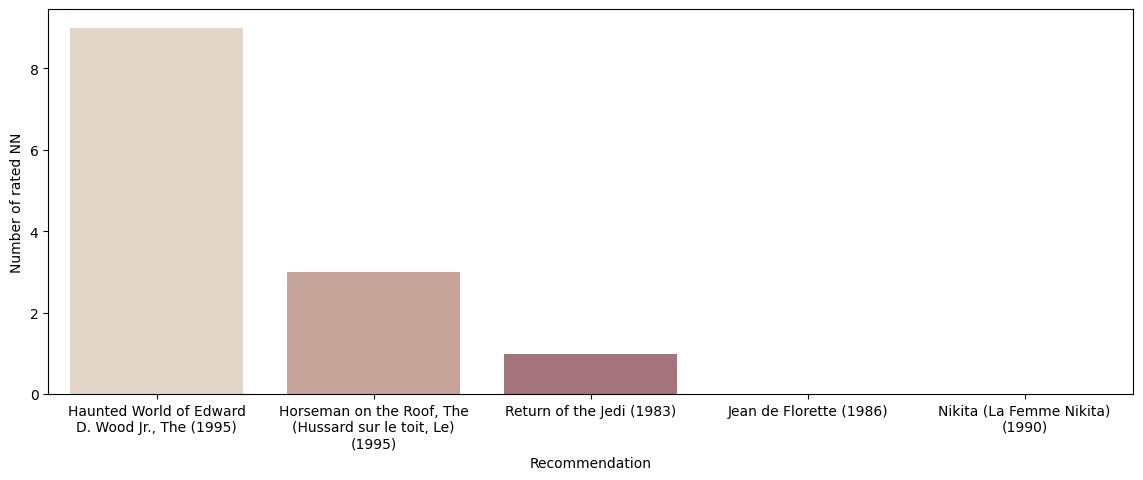

In [20]:
rated_items = np.nonzero(rating_mat[UIDX])[1]
n_nearest_neighbors = []
for rec in recommendations[:TOPK]:
  nearest_neighbors = np.argsort(iknn_adjusted.sim_mat[rec].A.ravel())[-K:]
  n_nearest_neighbors.append(len(np.intersect1d(nearest_neighbors, rated_items)))
rec_df["Number of rated NN"] = n_nearest_neighbors

fig, ax = plt.subplots(figsize=(14, 5))
sns.barplot(x="Recommendation", y="Number of rated NN", data=rec_df, palette="ch:.25", ax=ax);
ax.set_xticklabels(textwrap.fill(x.get_text(), 25) for x in ax.get_xticklabels());

In this case, the top recommendation is *Haunted World of Edward D. Wood Jr., The (1995)*, and 9 movies out of its 50 nearest-neighbors have been rated (probably watched) by the user.

## References

1.   Aggarwal, C. C. (2016). Recommender systems (Vol. 1). Cham: Springer International Publishing.
2.   Breese, J. S., Heckerman, D., & Kadie, C. (2013). Empirical analysis of predictive algorithms for collaborative filtering. arXiv preprint arXiv:1301.7363.
3.   Sarwar, B., Karypis, G., Konstan, J., & Riedl, J. (2001, April). Item-based collaborative filtering recommendation algorithms. In Proceedings of the 10th international conference on World Wide Web (pp. 285-295).

